In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

/Users/roedigerj/anaconda/envs/astro/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# READ IN ID'S AND MAGNITUDES OF NGVS GALAXIES

filePath = 'finalCat_fixColNames.txt'

columns = [0, 7, 8, 37, 45, 93, 101, 149, 157, 205, 213, 261, 269, 359, 390, 421, 452, 483]
dtypes = 'S27, f, f, f, f, f, f, f, f, f, f, f, f, f, f, f, f, f'

data = np.genfromtxt(filePath, dtype = dtypes, skip_header = 0, usecols = columns, names = True)
data

array([ (b'NGVSJ12:03:45.06+27:37:02.0',  180.93774414,  27.61722183, -100.        , -100.        , -100.        , -100.        , -100.        , -100.        , -100.        , -100.        , -100.        , -100.        ,  16.66900063,  17.52199936,   16.28899956,  16.08099937,   16.00600052),
       (b'NGVSJ12:04:51.83+26:59:33.1',  181.21595764,  26.99252701, -100.        , -100.        , -100.        , -100.        , -100.        , -100.        , -100.        , -100.        , -100.        , -100.        ,  13.6260004 ,  14.53199959,   13.14500046,  12.92099953,   12.74499989),
       (b'NGVSJ12:07:45.73+12:03:37.0',  181.94055176,  12.06027794, -100.        , -100.        , -100.        , -100.        , -100.        , -100.        , -100.        , -100.        , -100.        , -100.        ,  20.58200073,  21.80699921, -100.        ,  19.68000031,   19.70499992),
       ...,
       (b'NGVSJ12:31:41.52+11:48:04.6',  187.92298889,  11.80129147,   23.38699913,   23.35000038,   24.6970005

In [3]:
# STASH ID'S, COORDINATES, AND MAGNITUDES INTO SEPARATE ARRAYS

# create empty arrays for data
ngvsID = []
coords = np.empty((data.shape[0], 2), dtype = float)
mags_full = np.empty((data.shape[0], 15), dtype = float)

# stash data one galaxy at a time
for i in range(data.shape[0]):
    ngvsID.append(data['Official_name'][i].decode('UTF-8'))
    coords[i, 0] = data['NGVS_radeg'][i]
    coords[i, 1] = data['NGVS_decdeg'][i]
    
    k = 0
    for j in range(3):
        if j == 0:
            magType = ['', '_mag_cg']
        if j == 1:
            magType = ['', '_mag_bestfit']
        if j == 2:
            magType = ['MAG_GALFIT_', '_gal']
        
        for band in 'ugriz':
            mags_full[i, k] = data[magType[0] + band + magType[1]][i]
            k += 1

In [4]:
# CREATE ADDITIONAL ARRAY OF MAGNITUDES FOR GALAXIES LYING IN PILOT FIELD REGION
# [assuming PP galaxies are those having 15 distinct total mag measurements available]
# [n_PP = 355]

mags_PP = []
for i in range(mags_full.shape[0]):
    scratch = mags_full[i, :]
    #if np.sum(scratch > 0.) == 15:
    if (coords[i , 0] > 186.58333) and (coords[i , 0] < 188.54167) and \
       (coords[i , 1] >  11.50611) and (coords[i , 1] <  13.44583):
        mags_PP.append(scratch)
        
mags_PP = np.array(mags_PP)
mags_PP.shape

(404, 15)

In [5]:
# GENERATE MAGNITUDE ERRORS FOR PILOT FIELD GALAXIES [B/O STANDARD ERROR FORMULA]

magErrs_PP = np.empty((mags_PP.shape[0], 5))

for i in range(mags_PP.shape[0]):
    for j in range(5):
        
        n = 0.0
        sample = []
        for k in range(0, 15, 5):
            if (mags_PP[i, j + k] > 0.):
                sample.append(mags_PP[i, j + k])
                n += 1.0
                
        if (n <= 1.0): print (i, j)
        magErrs_PP[i, j] = np.std(sample, ddof = 1) / np.sqrt(n)
        #magErrs_PP[i, j] = np.std([mags_PP[i, j], mags_PP[i, j + 5], mags_PP[i, j + 10]], ddof = 1) / np.sqrt(3)
        

30 2
132 4
158 0


/Users/roedigerj/anaconda/envs/astro/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/roedigerj/anaconda/envs/astro/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/roedigerj/anaconda/envs/astro/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


403
404
403
404
403


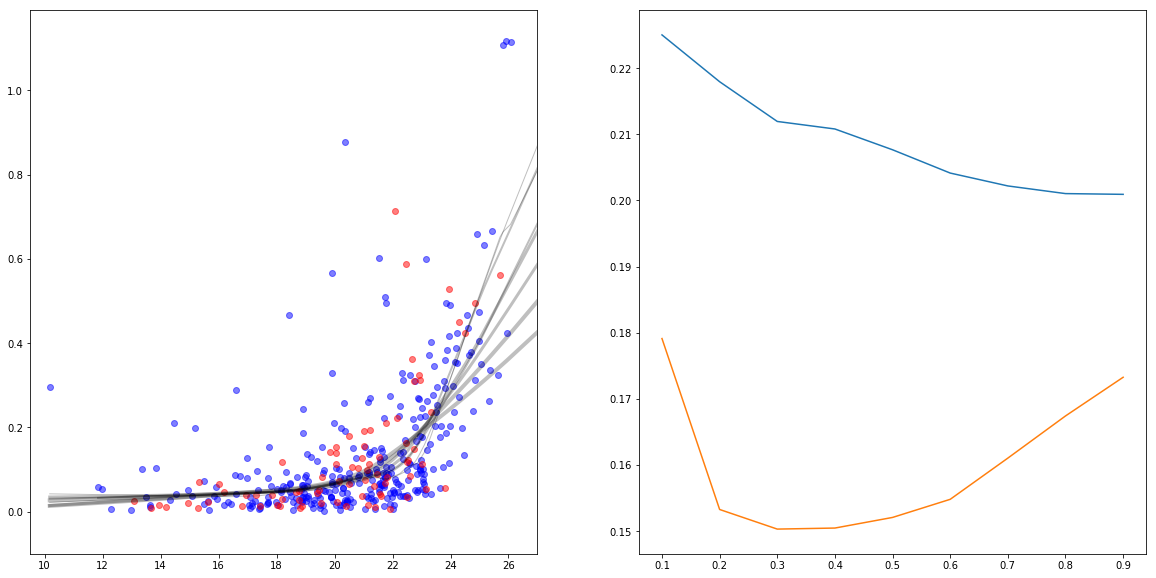

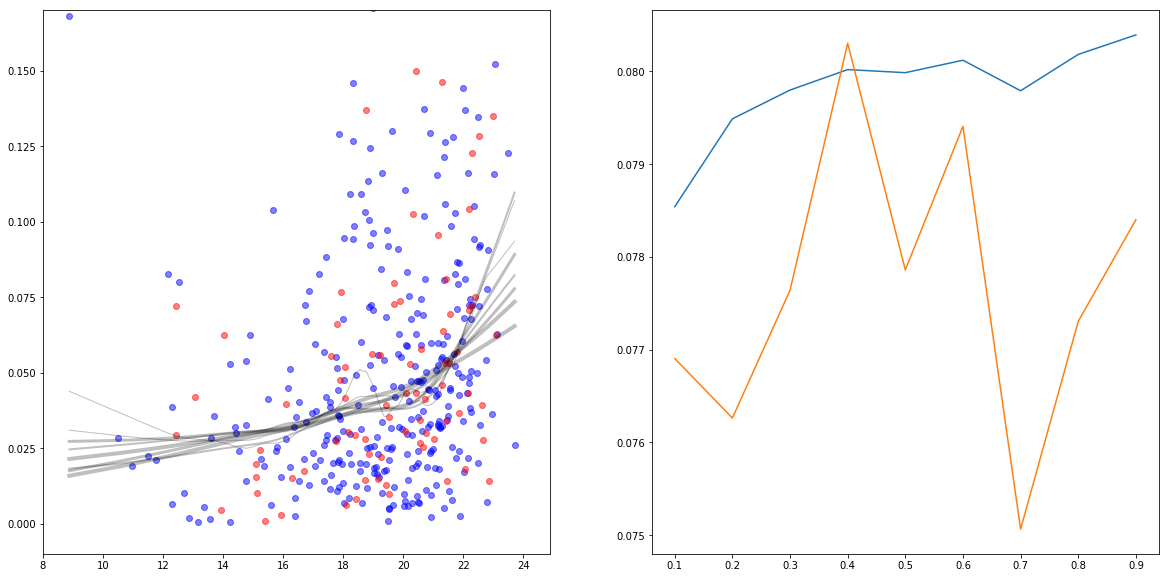

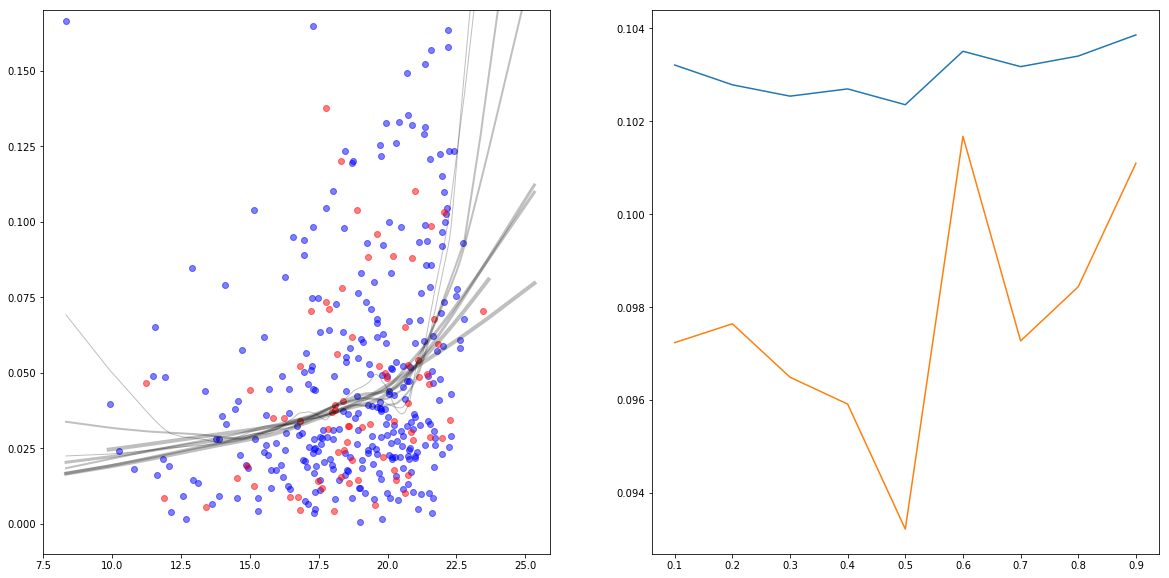

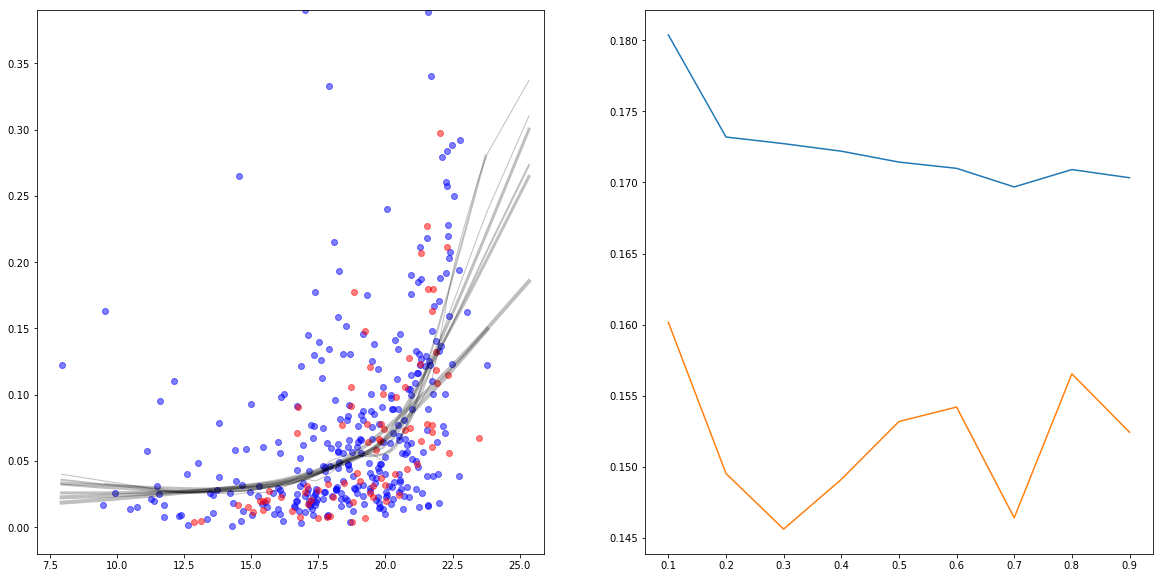

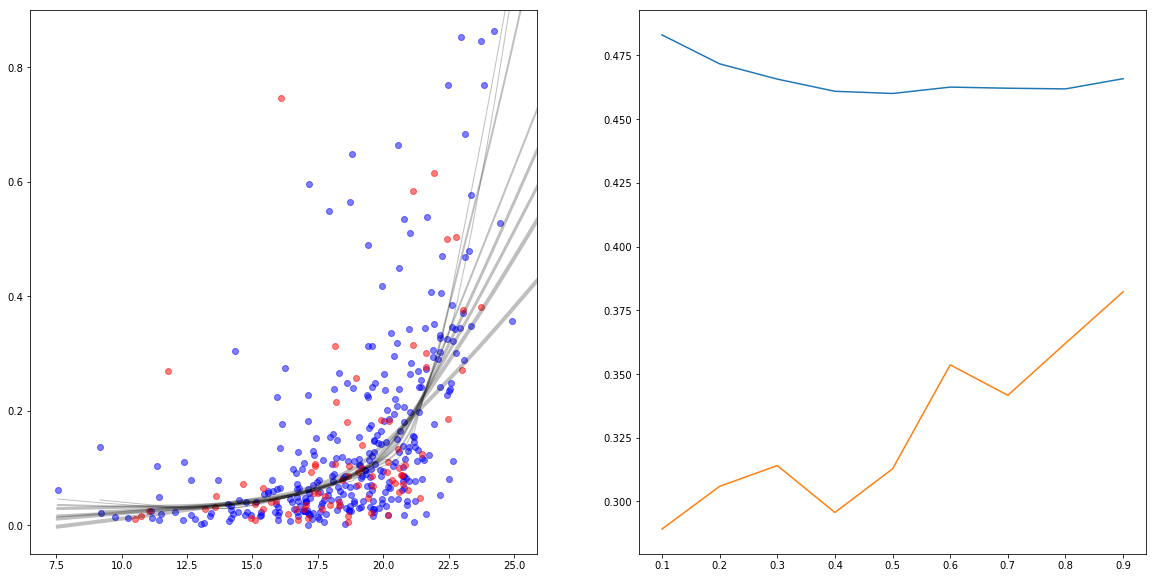

In [6]:
# WILL USE LOWESS ALGORITHM TO DETERMINE RELATIONSHIPS BETWEEN MAGNITUDE ERRORS AND MAGNITUDES

# USE K-FOLD CROSS-VALIDATION TO DETERMINE THE OPTIMAL SETTING OF THE FRAC PARAMETER IN LOWESS
# [OPTIMAL FRAC SOMEWHERE BETWEEN 0.2-0.4]

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from scipy.interpolate import interp1d

# initialize kfold iterator
kf = KFold(n_splits = 5, shuffle = True)

xlims = [[9.5, 27.0], [8.0, 24.9], [7.5, 25.9], [7.0, 25.9], [6.5, 25.9]]
ylims = [[-0.10, 1.19], [-0.01, 0.17], [-0.01, 0.17], [-0.02, 0.39], [-0.05, 0.90]]

# cycle through each filter
for j in range(5):
    fig = plt.figure(figsize = (20, 10))
    
    mask = ~np.isnan(magErrs_PP[:, j])
    mags = mags_PP[mask, j]
    magErrs = magErrs_PP[mask, j]
    print (mags.size)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    
    #-----
    
    # cycle through frac values, fit lowess curve (k times), and compute rms stats for training and test sets
    rms_train = np.zeros(9)
    rms_test = np.zeros(9)
    fracs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for i, frac in enumerate(fracs):
        
        k = 0
        for train, test in kf.split(mags):
            
            # smooth on training data
            scratch = np.vstack([mags[train], magErrs[train]]).T
            scratch = scratch[scratch[:, 0].argsort()]
            lowess = sm.nonparametric.lowess(scratch[:, 1], scratch[:, 0], frac = frac, it = 3)
            
            # interpolate LOWESS relationship (purging repeated mags), for purpose of predicting errors
            x, indxs = np.unique(lowess[:, 0], return_index = True)
            y = lowess[indxs, 1]
            func = interp1d(x, y, kind = 'cubic', bounds_error = False, fill_value = "extrapolate")
            magErrs_pred = func(mags[test])
            
            # compute stats of smoothed relation
            rms_train[i] += np.sqrt(np.sum((lowess[:, 1] - magErrs[train]) ** 2) / 
                                    float(mags[train].size - 1))
            rms_test[i] += np.sqrt(np.sum((magErrs_pred - magErrs[test]) ** 2) / 
                                   float(mags[test].size - 1))
            
            # plot training and test data (once)
            if frac == 0.1 and k == 0:
                ax1 = plt.subplot(121)
                ax1.scatter(mags[train], magErrs[train], facecolor = 'blue', alpha = 0.5)
                ax1.scatter(mags[test], magErrs[test], facecolor = 'red', alpha = 0.5)
                ax1.set_xlim(xlims[j])
                ax1.set_ylim(ylims[j])
                
            # plot LOWESS curves for frac = 0.1
            if k == 0:
                ax1.plot(lowess[:, 0], lowess[:, 1], c = 'k', lw = int(5. * frac), alpha = 0.25)
                
            k += 1
            
        # compute average of k folds
        rms_train[i] /= 5.0
        rms_test[i] /= 5.0
        
    # plot rms curves determined from training and test sets
    ax2 = plt.subplot(122)
    ax2.plot(fracs, rms_train)
    ax2.plot(fracs, rms_test);

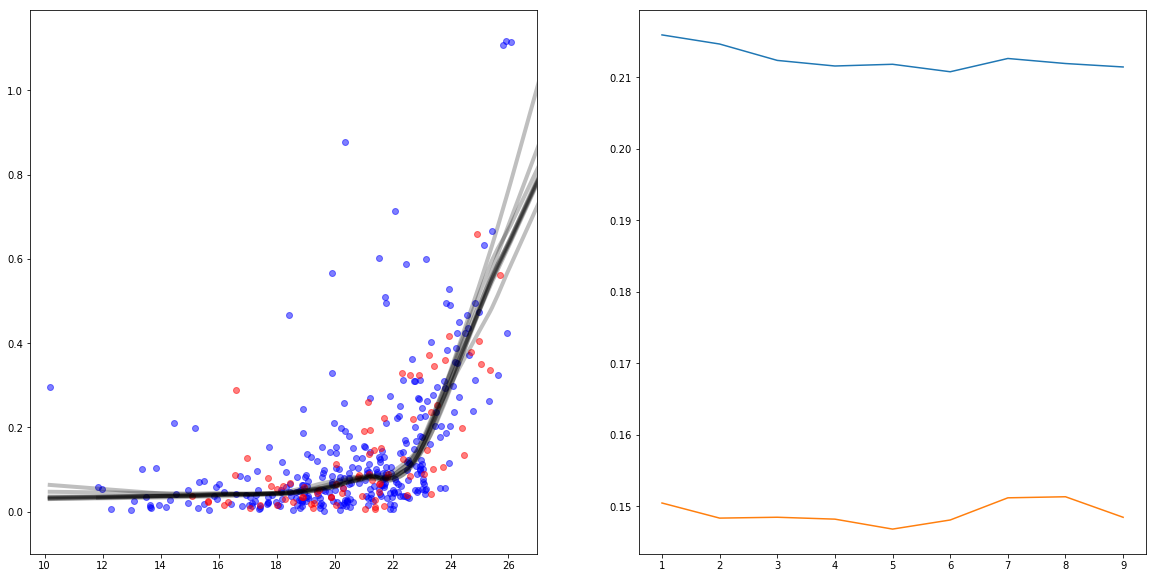

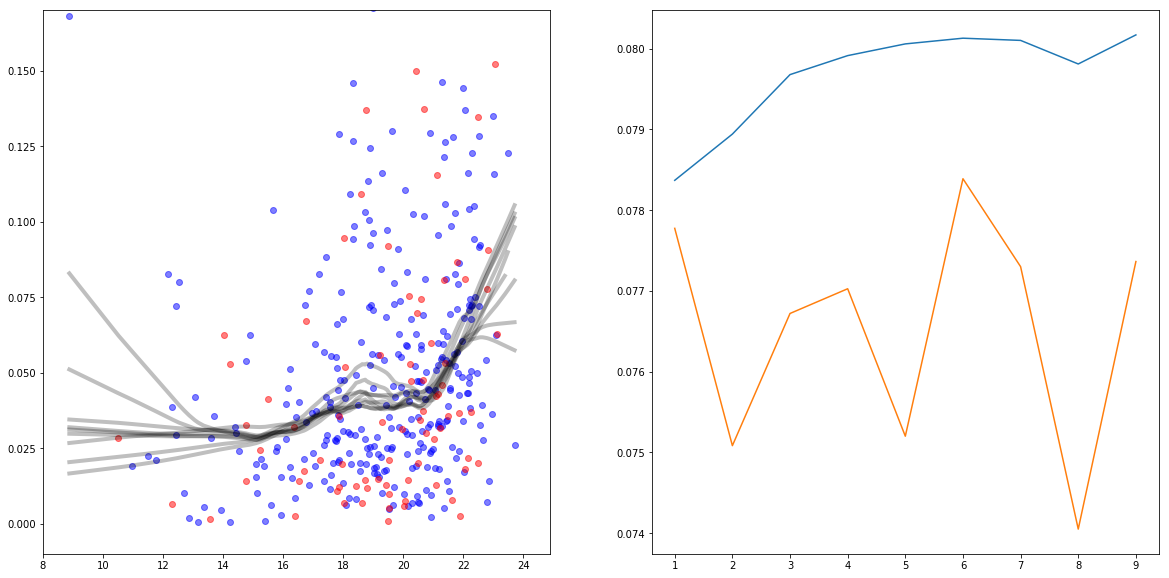

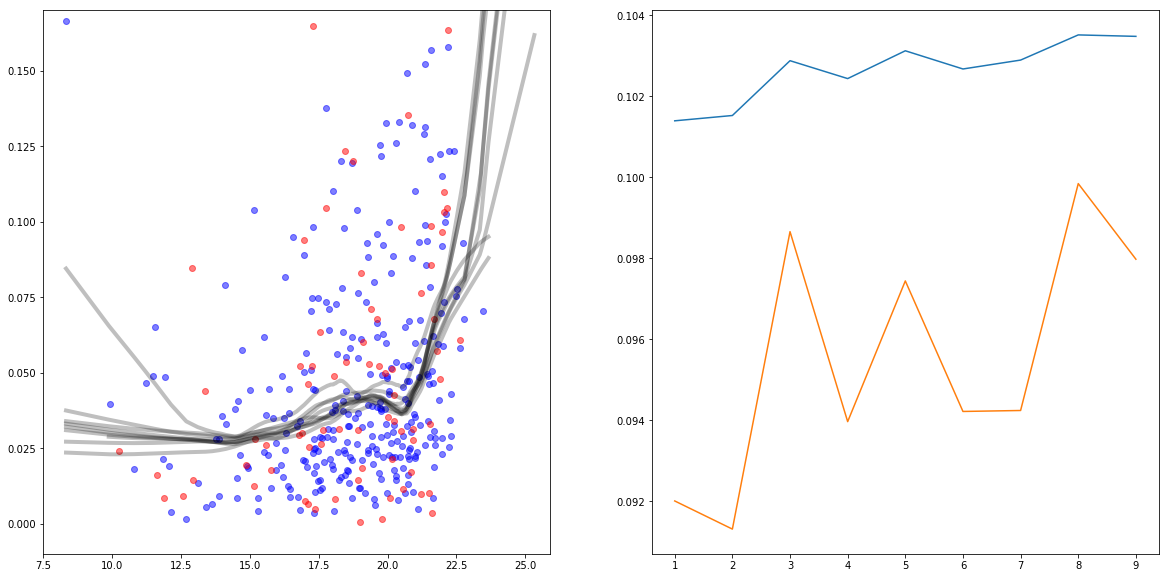

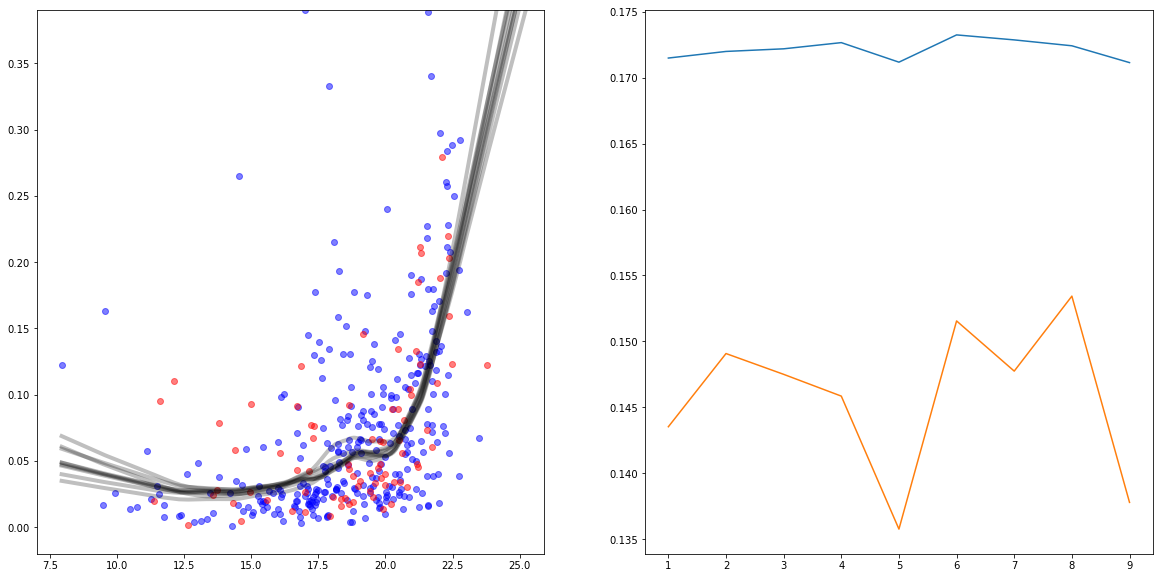

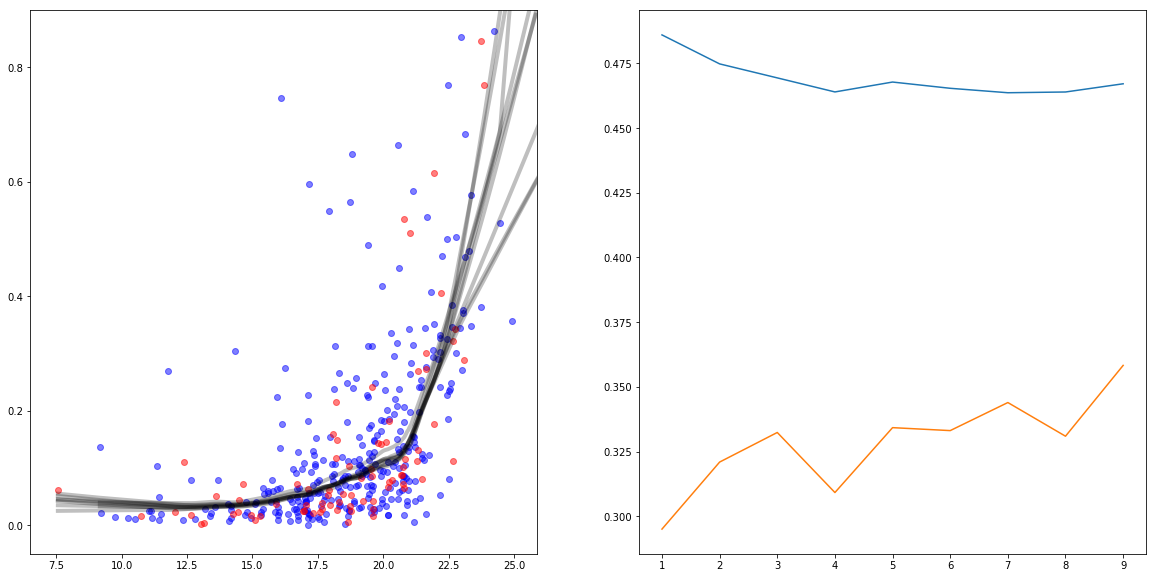

In [7]:
# USE K-FOLD CROSS-VALIDATION TO DETERMINE THE OPTIMAL SETTING OF THE ITER PARAMETER IN LOWESS
# [OPTIMAL ITER SOMEWHERE BETWEEN 2-5, ARGUABLY 2/5]

# initialize kfold iterator
kf = KFold(n_splits = 5, shuffle = True)

xlims = [[9.5, 27.0], [8.0, 24.9], [7.5, 25.9], [7.0, 25.9], [6.5, 25.9]]
ylims = [[-0.10, 1.19], [-0.01, 0.17], [-0.01, 0.17], [-0.02, 0.39], [-0.05, 0.90]]

# cycle through each filter
for j in range(5):
    fig = plt.figure(figsize = (20, 10))
    
    mask = ~np.isnan(magErrs_PP[:, j])
    mags = mags_PP[mask, j]
    magErrs = magErrs_PP[mask, j]
    
    #-----
    
    # cycle through iter values, fit lowess curve (k times), and compute rms stats for training and test sets
    rms_train = np.zeros(9)
    rms_test = np.zeros(9)
    iters = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    for i, it in enumerate(iters):
        
        k = 0
        for train, test in kf.split(mags):
            
            # smooth on training data
            scratch = np.vstack([mags[train], magErrs[train]]).T
            scratch = scratch[scratch[:, 0].argsort()]
            lowess = sm.nonparametric.lowess(scratch[:, 1], scratch[:, 0], frac = 0.3, it = it)
            
            # interpolate LOWESS relationship (purging repeated mags), for purpose of predicting errors
            x, indxs = np.unique(lowess[:, 0], return_index = True)
            y = lowess[indxs, 1]
            func = interp1d(x, y, kind = 'cubic', bounds_error = False, fill_value = "extrapolate")
            magErrs_pred = func(mags[test])
            
            # compute stats of smoothed relation
            rms_train[i] += np.sqrt(np.sum((lowess[:, 1] - magErrs[train]) ** 2) / 
                                    float(mags[train].size - 1))
            rms_test[i] += np.sqrt(np.sum((magErrs_pred - magErrs[test]) ** 2) / 
                                   float(mags[test].size - 1))
            
            # plot training and test data (once)
            if it == 1 and k == 0:
                ax1 = plt.subplot(121)
                ax1.scatter(mags[train], magErrs[train], facecolor = 'blue', alpha = 0.5)
                ax1.scatter(mags[test], magErrs[test], facecolor = 'red', alpha = 0.5)
                ax1.set_xlim(xlims[j])
                ax1.set_ylim(ylims[j])
                
            # plot LOWESS curves for frac = 0.1
            if k == 0:
                ax1.plot(lowess[:, 0], lowess[:, 1], c = 'k', lw = int(5. * frac), alpha = 0.25)
                
            k += 1
            
        # compute average of k folds
        rms_train[i] /= 5.0
        rms_test[i] /= 5.0
        
    # plot (scaled) rms curves determined from training and test sets
    ax2 = plt.subplot(122)
    ax2.plot(iters, rms_train)
    ax2.plot(iters, rms_test);

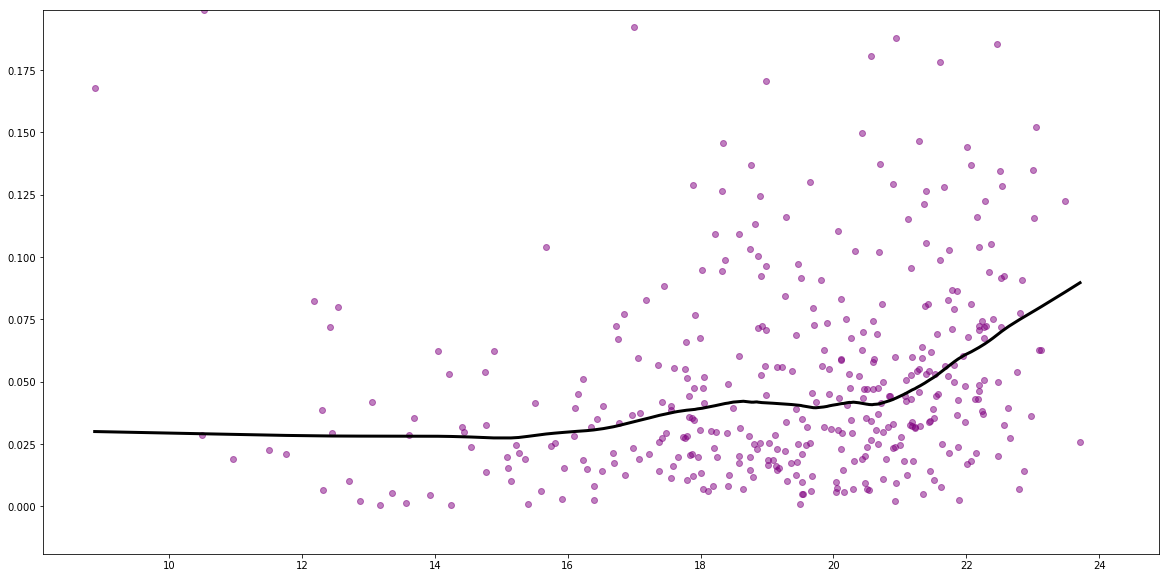

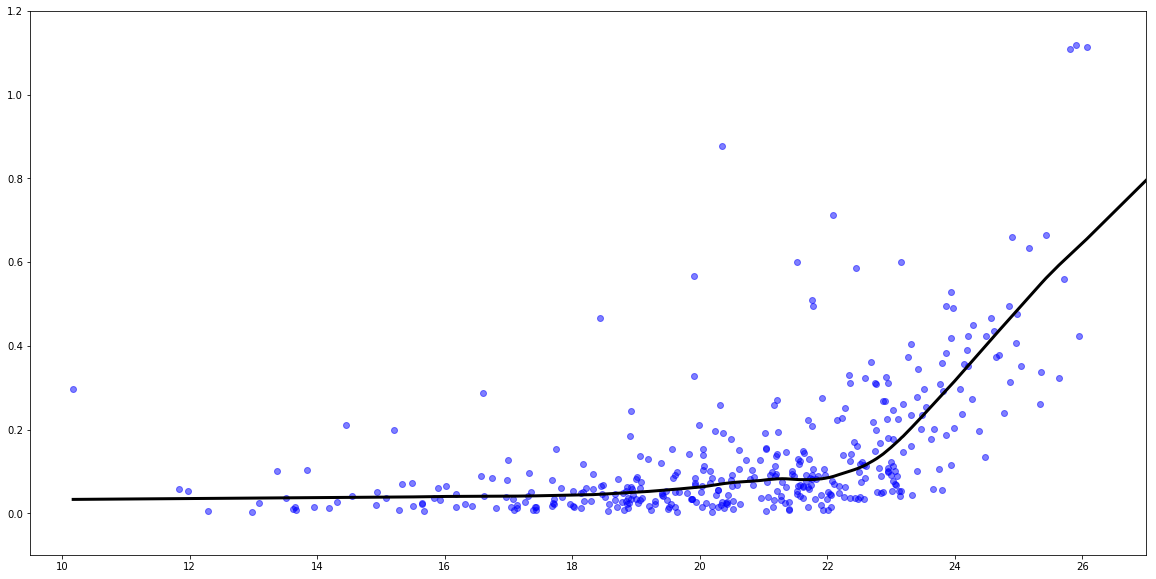

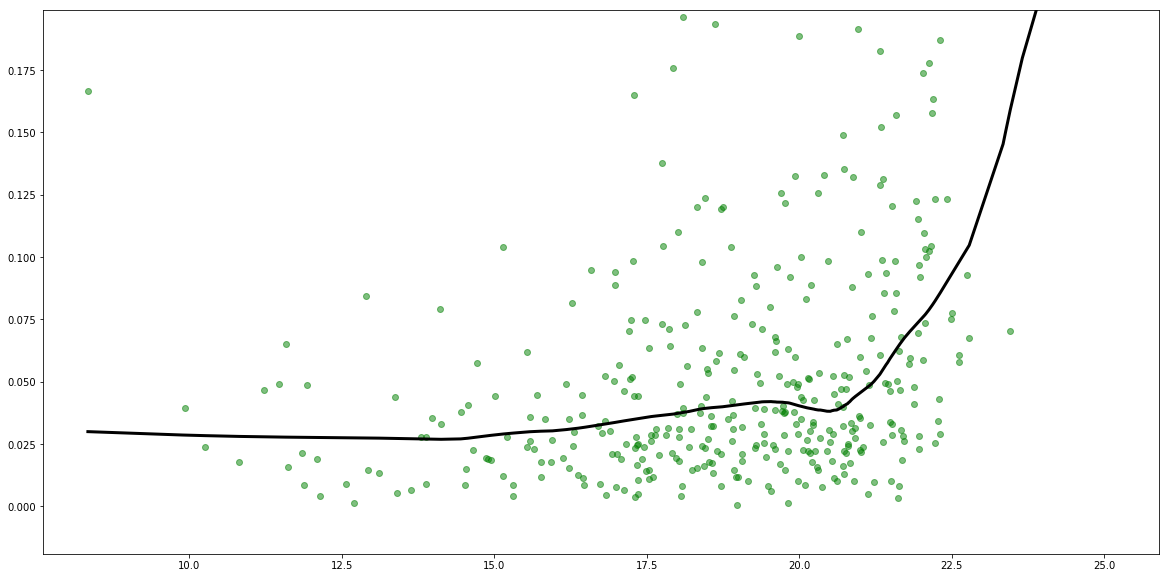

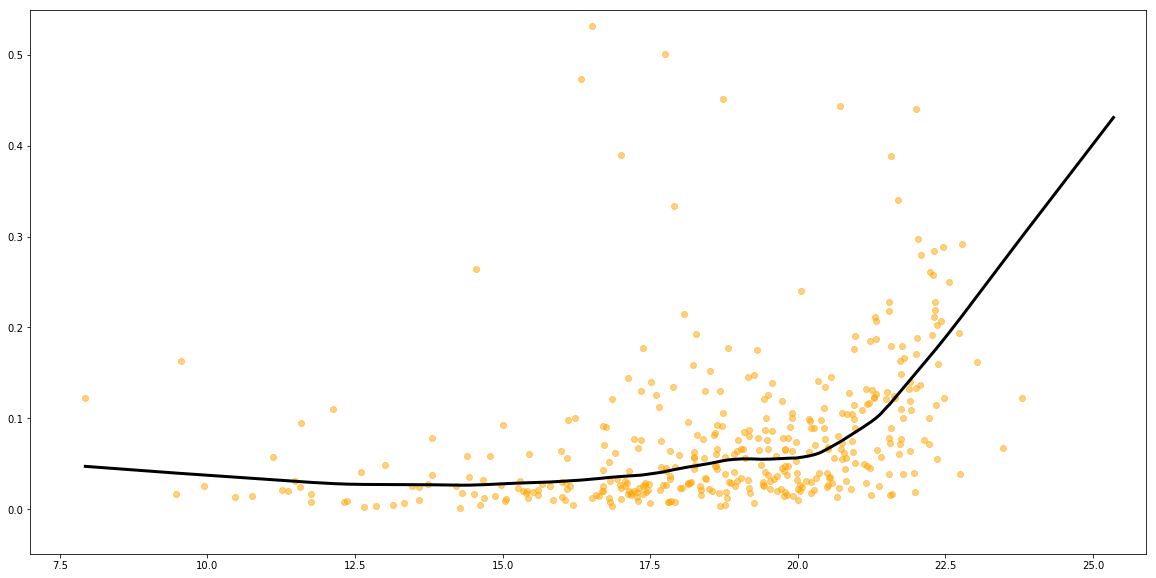

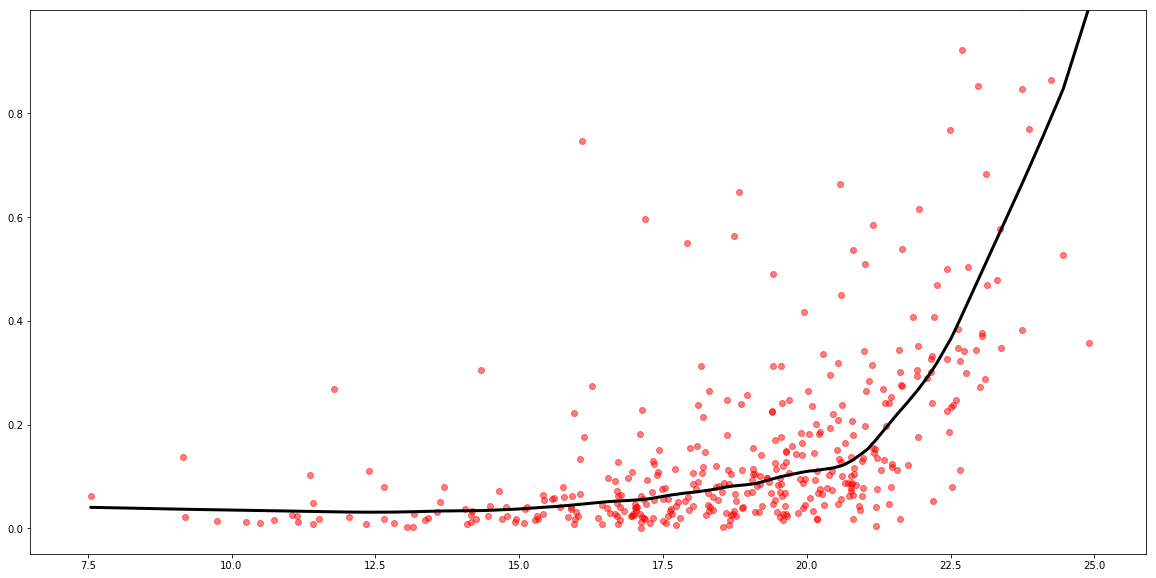

In [8]:
# DETERMINE, PLOT, AND STORE LOWESS FITS FOR COG MAGNITUDES USING OPTIMAL PARAMETERS

magErrs_pred = -100.0 * np.ones(mags_full.shape)

idxs = [1, 0, 2, 3, 4]
bands = ['u', 'g', 'r', 'i', 'z']

colors = ['purple', 'blue', 'green', 'orange', 'red']
xlims = [[8.1, 24.9], [9.5, 27.0], [7.6, 25.9], [7.0, 25.9], [6.5, 25.9]]
ylims = [[-0.019, 0.199], [-0.099, 1.199], [-0.019, 0.199], [-0.049, 0.549], [-0.049, 0.999]]

# cycle through each band
for idx, band, color, xlim, ylim in zip(idxs, bands, colors, xlims, ylims):
    # determine LOWESS solution
    mask = ~np.isnan(magErrs_PP[:, idx])
    scratch = np.vstack([mags_PP[mask, idx], magErrs_PP[mask, idx]]).T
    scratch = scratch[scratch[:, 0].argsort()]
    lowess = sm.nonparametric.lowess(scratch[:, 1], scratch[:, 0], frac = 0.3, it = 3)
    
    # write LOWESS solution to file (omitting repeated values)
    f = open('lowess_magErrsVsMags_' + band + '_x=cg.txt', 'w')
    
    x, indxs = np.unique(lowess[:, 0], return_index = True)
    y = lowess[indxs, 1]
    for i in range(lowess.shape[0]):
        if i in indxs:
            f.write('%8.4f %9.5f\n' % (lowess[i, 0], lowess[i, 1]))
    f.close()
    
    # interpolate LOWESS solution and predict magnitude errors therefrom
    mask = (mags_full[:, idx] > 0.)
    func = interp1d(x, y, kind = 'cubic', bounds_error = False, fill_value = "extrapolate")
    magErrs_pred[mask, idx] = func(mags_full[mask, idx])
    #magErrs_pred[~mask, idx] = -100.
    
    # fix erroneous values caused by extrapolation
    mask = ((mags_full[:, idx] < lowess[0, 0]) & (mags_full[:, idx] > 0.))
    magErrs_pred[mask, idx] = lowess[0, 1]
    
    mask = (mags_full[:, idx] > lowess[-1, 0])
    magErrs_pred[mask, idx] = lowess[-1, 1]
    
    # plot data and LOWESS solution
    fig = plt.figure(figsize = (20, 10))
    ax1 = plt.subplot(111)
    ax1.scatter(mags_PP[:, idx], magErrs_PP[:, idx], facecolor = color, alpha = 0.5)
    ax1.plot(lowess[:, 0], lowess[:, 1], c = 'k', lw = 3)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    plt.savefig('magErrsVsMags_' + band + '_x=cg.pdf');

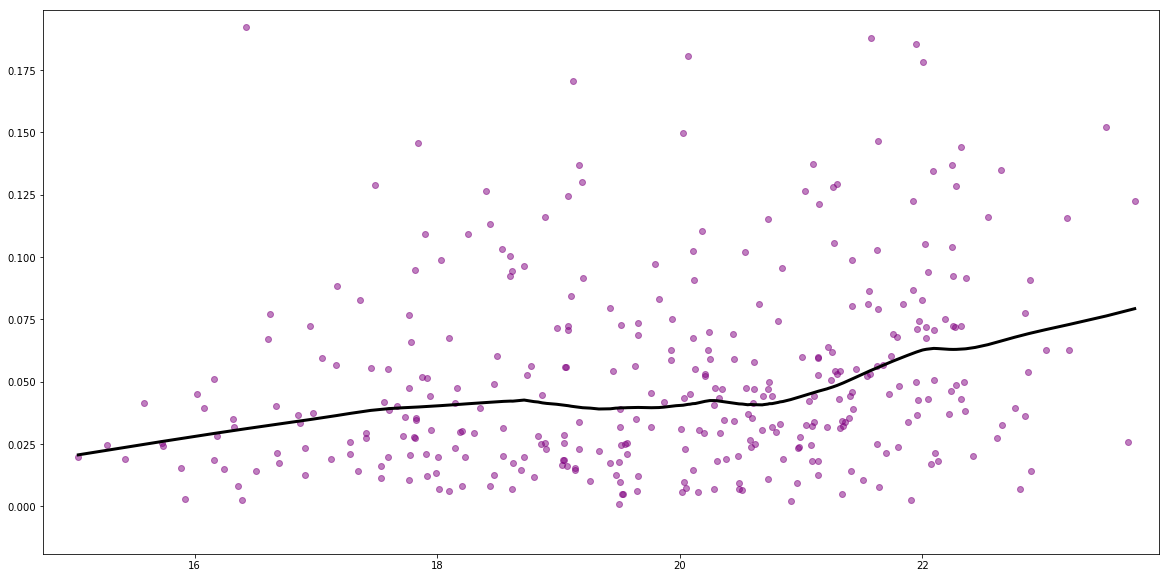

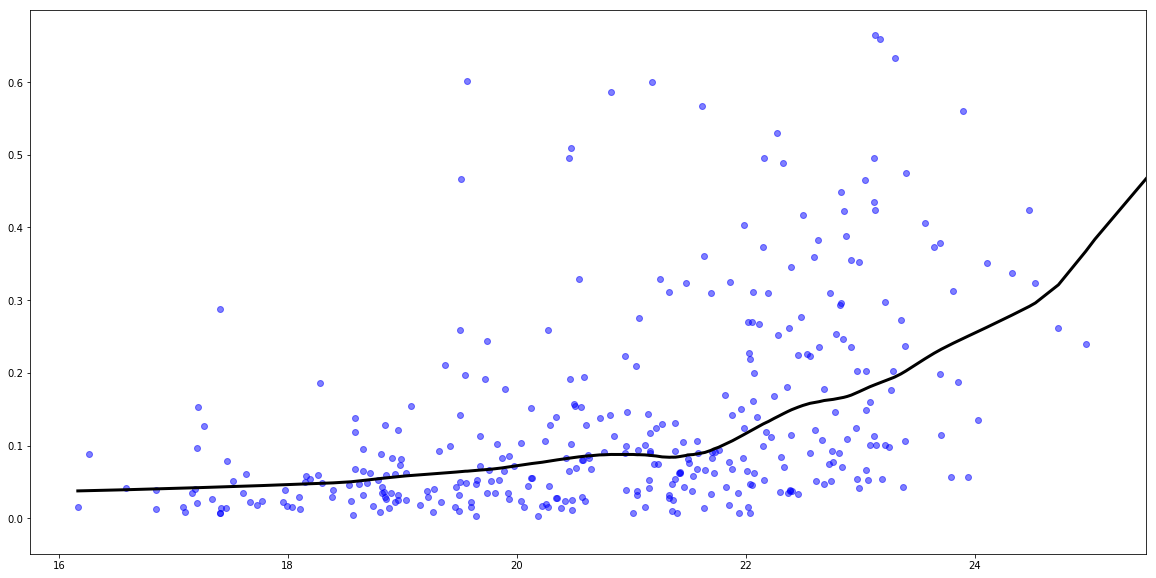

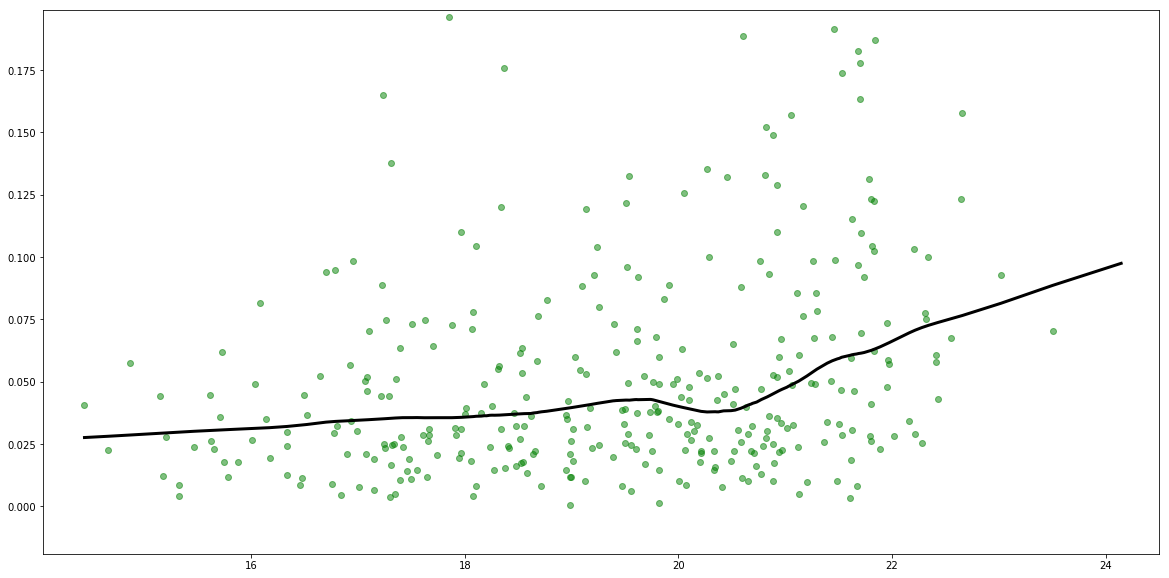

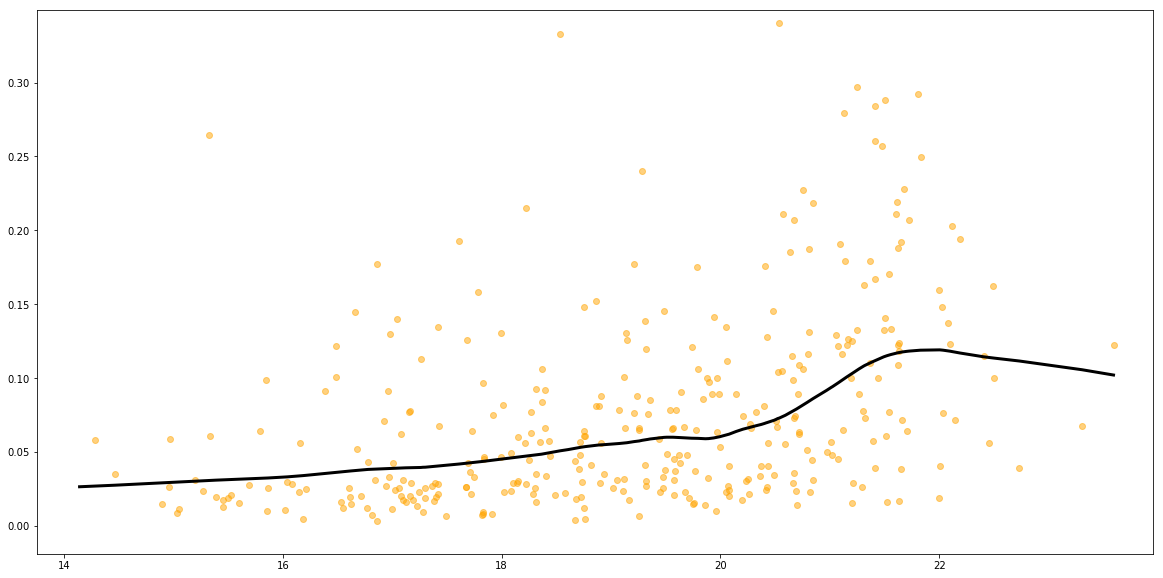

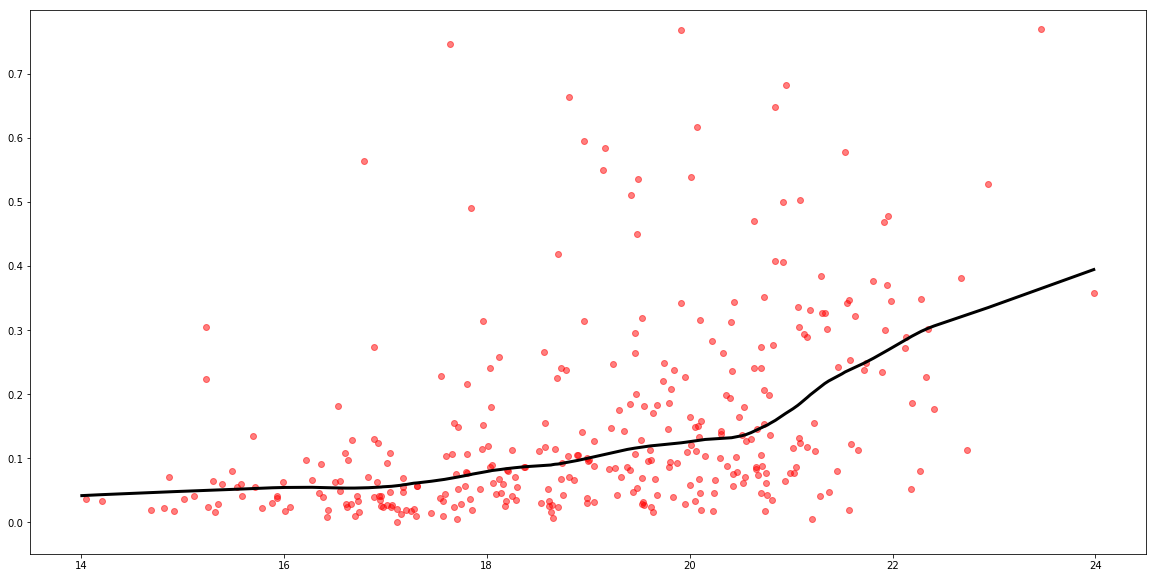

In [9]:
# DETERMINE, PLOT, AND STORE LOWESS FITS FOR GALFIT MAGNITUDES USING OPTIMAL PARAMETERS

idxs = [1, 0, 2, 3, 4]
bands = ['u', 'g', 'r', 'i', 'z']

colors = ['purple', 'blue', 'green', 'orange', 'red']
xlims = [[14.75, 23.95], [15.75, 25.50], [14.05, 24.50], [13.75, 23.95], [13.50, 24.50]]
ylims = [[-0.019, 0.199], [-0.049, 0.699], [-0.019, 0.199], [-0.019, 0.349], [-0.049, 0.799]]

# cycle through each band
for idx, band, color, xlim, ylim in zip(idxs, bands, colors, xlims, ylims):
    # determine LOWESS solution
    mask = (mags_PP[:, idx + 10] > 0.) & (mags_PP[:, idx + 10] < 30.) & (~np.isnan(magErrs_PP[:, idx]))
    scratch = np.vstack([mags_PP[mask, idx + 10], magErrs_PP[mask, idx]]).T
    scratch = scratch[scratch[:, 0].argsort()]
    lowess = sm.nonparametric.lowess(scratch[:, 1], scratch[:, 0], frac = 0.3, it = 3)
    
    # write LOWESS solution to file
    f = open('lowess_magErrsVsMags_' + band + '_x=galfit.txt', 'w')
    
    x, indxs = np.unique(lowess[:, 0], return_index = True)
    y = lowess[indxs, 1]
    for i in range(lowess.shape[0]):
        if i in indxs:
            f.write('%8.4f %9.5f\n' % (lowess[i, 0], lowess[i, 1]))
    f.close()
    
    # interpolate LOWESS solution and predict magnitude errors therefrom
    mask = (mags_full[:, idx + 10] > 0.)
    func = interp1d(x, y, kind = 'cubic', bounds_error = False, fill_value = "extrapolate")
    magErrs_pred[mask, idx + 10] = func(mags_full[mask, idx + 10])
    #magErrs_pred[~mask, idx + 10] = -100.
    
    # fix erroneous values caused by extrapolation
    mask = ((mags_full[:, idx + 10] < lowess[0, 0]) & (mags_full[:, idx + 10] > 0.))
    magErrs_pred[mask, idx + 10] = lowess[0, 1]
    
    mask = (mags_full[:, idx + 10] > lowess[-1, 0])
    magErrs_pred[mask, idx + 10] = lowess[-1, 1]
    
    # plot data and LOWESS solution
    fig = plt.figure(figsize = (20, 10))
    ax1 = plt.subplot(111)
    ax1.scatter(mags_PP[:, idx + 10], magErrs_PP[:, idx], facecolor = color, alpha = 0.5)
    ax1.plot(lowess[:, 0], lowess[:, 1], c = 'k', lw = 3)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    plt.savefig('magErrsVsMags_' + band + '_x=galfit.pdf');

In [10]:
# WRITE MAGNITUDES AND THEIR ERRORS TO FILE

f = open('mags_ngvsFull.txt', 'w')

for i in range(mags_full.shape[0]):
    string = '%s' % (ngvsID[i])
    #string = '%10.4f %12.5f' % (mags_full[i, 0], magErrs_pred[i, 0])
    for j in range(0, 15):
        if j < 5 or j > 9:
            string += '%12.4f %12.5f' % (mags_full[i, j], magErrs_pred[i, j])
        
    f.write(string + '\n')
    
f.close()

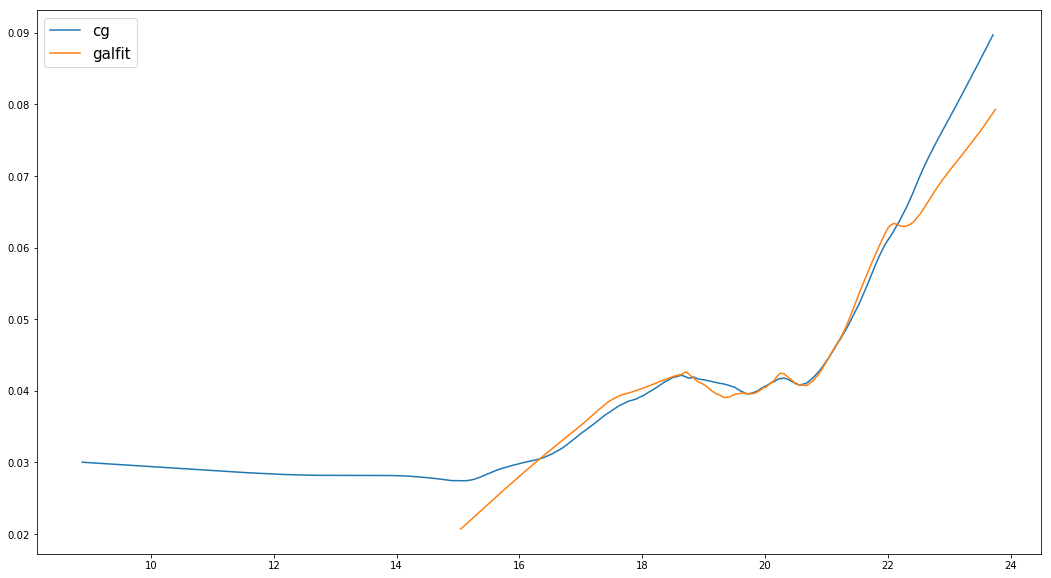

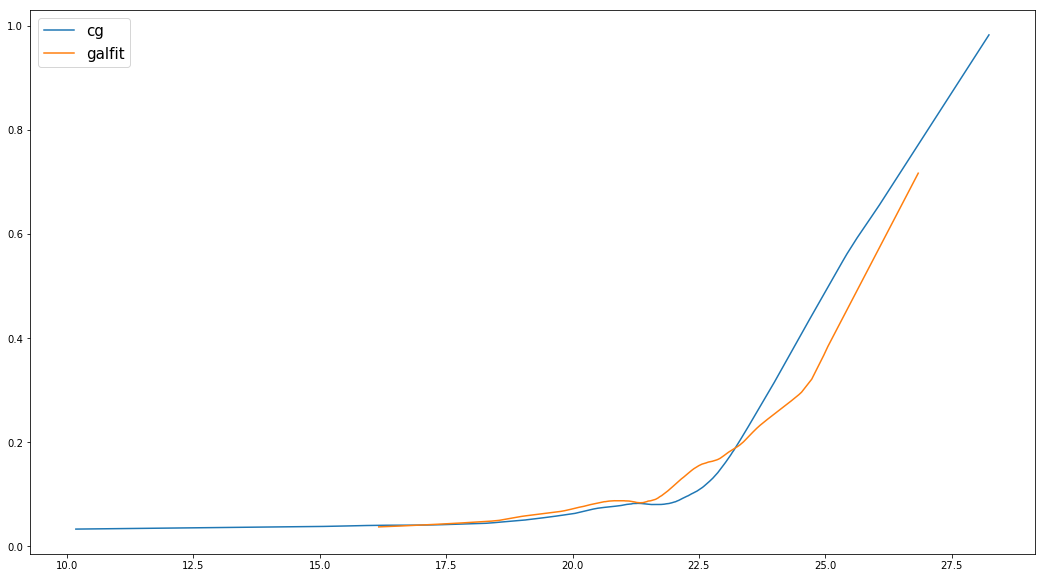

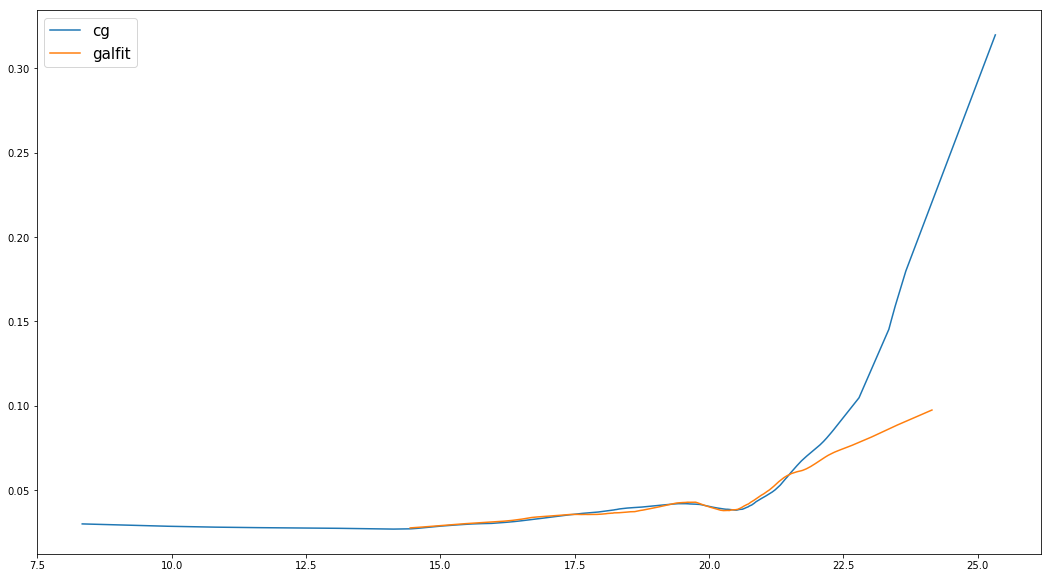

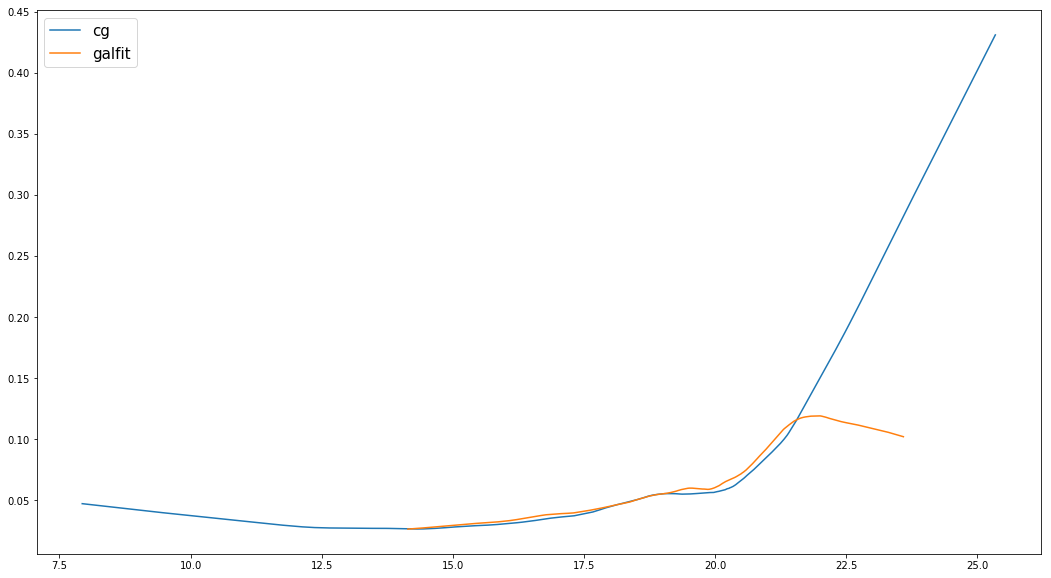

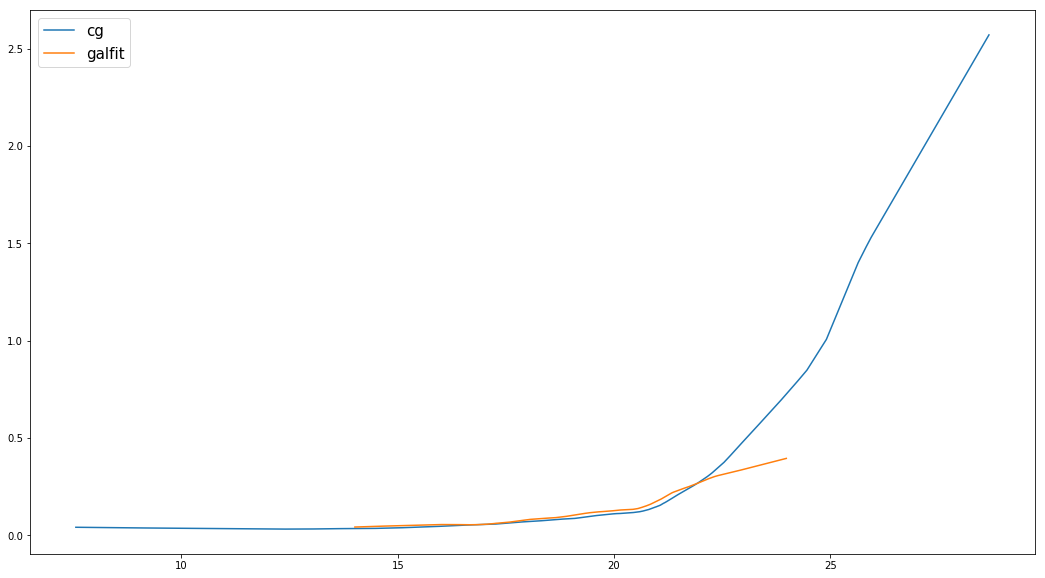

In [11]:
# COMPARE LOWESS FITS B/O COG AND GALFIT MAGNITUDES FOR EACH BAND

for band in ['u', 'g', 'r', 'i', 'z']:
    
    f = 'lowess_magErrsVsMags_' + band + '_x=cg.txt'
    data_cg = np.genfromtxt(f)
    
    f = 'lowess_magErrsVsMags_' + band + '_x=galfit.txt'
    data_galfit = np.genfromtxt(f)
    
    fig = plt.figure(figsize = (18, 10))
    ax = plt.subplot(111)
    ax.plot(data_cg[:, 0], data_cg[:, 1], label = 'cg')
    ax.plot(data_galfit[:, 0], data_galfit[:, 1], label = 'galfit')
    ax.legend(fontsize = 15)
    
    plt.savefig('compLowess_magErrVsMag_' + band + '.pdf');